### Upload dataset

In [ ]:
!wget https://conradsanderson.id.au/lfwcrop/lfwcrop_color.zip

--2024-05-12 18:40:19--  https://conradsanderson.id.au/lfwcrop/lfwcrop_color.zip
Resolving conradsanderson.id.au (conradsanderson.id.au)... 43.250.142.19, 2400:b800:3:1::1a
Connecting to conradsanderson.id.au (conradsanderson.id.au)|43.250.142.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152404390 (145M) [application/zip]
Saving to: ‘lfwcrop_color.zip’

lfwcrop_color.zip   100%[===================>] 145.34M  30.7MB/s    in 5.4s    

2024-05-12 18:40:25 (27.1 MB/s) - ‘lfwcrop_color.zip’ saved [152404390/152404390]



In [ ]:
!unzip -qq lfwcrop_color.zip

### Import Libaries

In [ ]:
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt

import numpy as np
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D

### Import dataset and preproccesing

In [ ]:
file_list = glob('/content/lfwcrop_color/faces/*.ppm')

images = [np.array(Image.open(file)) for file in file_list]

In [ ]:
noisy_images = []
for img_array in images:
    # Generate Gaussian noise
    noise = np.random.normal(0, 25.5, img_array.shape)
    noisy_img = img_array + noise
    noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
    noisy_images.append(noisy_img)

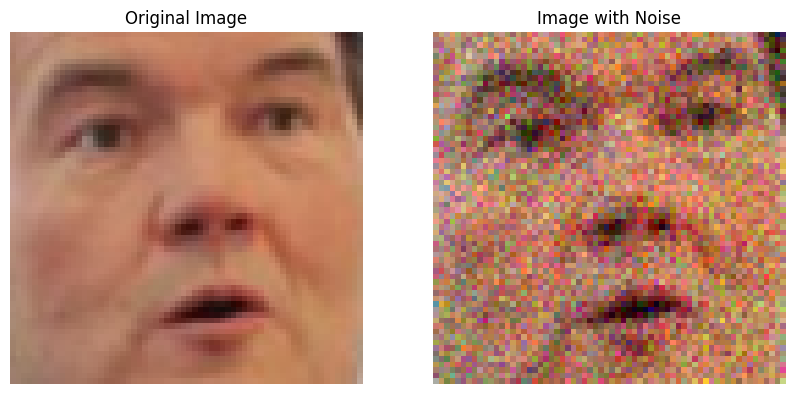

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[0].astype(np.uint8))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_images[0])
plt.title('Image with Noise')
plt.axis('off')
plt.show()

In [ ]:
X = np.array(noisy_images)
y = np.array(images)

# First split into training and temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temp set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = X_train.astype('float32') / 255
y_train = y_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
y_val = y_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_test = y_test.astype('float32') / 255

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 9263
Validation set size: 1985
Test set size: 1985


In [ ]:
model = Sequential([
    # Encoder
    Conv2D(32, (3, 3), activation='relu', padding='same', strides=2, input_shape=(64,64,3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    # Decoder
    Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
    UpSampling2D((2, 2)),
    Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 8, 8, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose_8 (Conv2D  (None, 16, 16, 64)        36928     
 Transpose)                                                      
                                                      

### Model Architecture:

### Encoder:
1. **Conv2D Layer:** The first layer is a 2D convolution layer with 32 filters and a kernel size of 3x3. The activation function is ReLU, which helps to introduce non-linearity into the model enabling it to learn more complex patterns. The padding is set to 'same', ensuring that the output of the convolution has the same dimensions as the input, while the strides are set to 2, reducing the spatial dimensions by half.
2. **MaxPooling2D Layer:** Following the convolution layer is a 2D max pooling layer with a pool size of 2x2 and 'same' padding. This layer reduces the spatial dimensions further, helps in extracting the dominant features.
3. **Second Conv2D Layer:** Increases the depth of the feature maps to 64, using the same kernel size and activation function. This layer continues the process of feature extraction.
4. **Second MaxPooling2D Layer:** Further reduces the spatial dimensions, concentrating the feature information into a more compact form.

### Decoder:

1. **Conv2DTranspose Layer:** This layer is essentially the reverse of a Conv2D layer. It increases the spatial dimensions of the feature maps. It has 64 filters, uses a kernel size of 3x3, stride of 2, and 'relu' activation. The padding is 'same'.
2. **UpSampling2D Layer:** Doubles the dimensions of the output from the previous layer, helping to reconstruct the spatial hierarchy.
3. **Second Conv2DTranspose Layer:** Further increases the spatial dimensions, now using 32 filters. This continues to upscale the image back towards its original size.
4. **Output Conv2D Layer:** The final convolutional layer has 3 filters (for RGB channels) and a sigmoid activation function. This layer ensures the output pixel values are normalized between 0 and 1, making it suitable for processing images where pixel values must be valid RGB values.



In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

### Loss function

MSE is used as the loss function. This is a common choice for regression problems, where we minimise the average squared difference between the estimated values and what is estimated. MSE will compute the square of the pixel-wise difference between the output of the model (the denoised image) and the target data (the original, clean image). It is effective in image denoising because it emphasises larger errors and thus drives the model to pay more attention to larger discrepancies between the denoised and original images.

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32,verbose=1, validation_data=(X_val, y_val))

Epoch 1/20
290/290 [==============================] - 5s 13ms/step - loss: 0.0107 - val_loss: 0.0048
Epoch 2/20
290/290 [==============================] - 3s 11ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 3/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 4/20
290/290 [==============================] - 3s 11ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 5/20
290/290 [==============================] - 3s 12ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 6/20
290/290 [==============================] - 3s 11ms/step - loss: 0.0027 - val_loss: 0.0026
Epoch 7/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0025 - val_loss: 0.0025
Epoch 8/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0024 - val_loss: 0.0024
Epoch 9/20
290/290 [==============================] - 3s 10ms/step - loss: 0.0024 - val_loss: 0.0023
Epoch 10/20
290/290 [==============================] - 3s 11ms/step - loss: 0.0023 - val_lo

In [ ]:
test_loss = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)

63/63 [==============================] - 0s 6ms/step - loss: 0.0018
Test Loss: 0.001847136183641851


### Result on a handful of noisy test images

63/63 [==============================] - 0s 5ms/step


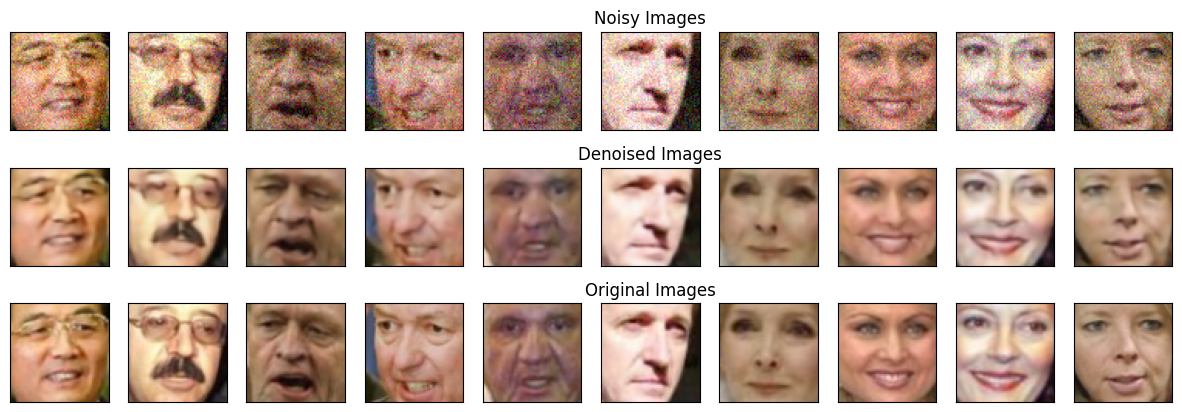

In [ ]:
def display_images(noisy, denoised, original, n=10):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        # Display noisy image
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(noisy[i].astype('uint8'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Noisy Images')

        # Display denoised image
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow((denoised[i] * 255).astype('uint8'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Denoised Images')

        # Display original image
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(original[i].astype('uint8'))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n//2:
            ax.set_title('Original Images')

    plt.show()

predicted_denoised_images = model.predict(X_test)

display_images(X_test * 255, predicted_denoised_images, y_test * 255, n=10)


As seen above the model has effectively reduced the noise. This indicates that the model is learning to filter out unwanted noise patterns.

There is some loss of detail, which can be a trade-off in denoising models. The model might be overly smoothing some areas, leading to a loss of subtle features that are important for image quality.

The colors in the denoised images is consistent with the original, which is good. However, the contrast may be slightly reduced, which could be contributing to the perceived loss in detail.